In [10]:
# https://www.tensorflow.org/datasets/api_docs/python/tfds/load
# https://www.tensorflow.org/datasets/catalog/malaria?hl=pt-br

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Input, BatchNormalization, Layer
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import BinaryAccuracy
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
dataset, dataset_info = tfds.load(
    "malaria",
    with_info=True,
    as_supervised=True,
    shuffle_files=True,
    split=["train"]
    # This dataset in particular has not been splitted previously for us.
    # split=["train", "test"]
)
print(dataset)
print(dataset_info)

[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]
tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='/home/albert/tensorflow_datasets/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018

I0000 00:00:1729962890.009571   55550 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2865 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1


# Familiarizing

In [ ]:
# from_logits = False -> assumes the input values are between 0 and 1
bce = BinaryCrossentropy(from_logits = False)
test_true = tf.constant([1, 0, 0, 1])
# test_pred = tf.constant([1, 0, 0, 1])
test_pred = tf.constant([1, 0, 1, 0])

# The closer test_pred is to test_true, the lower the output of BCE.
# If they're equal, the value is a very small value (closes to zero, like 1.192093e-07)
bce(test_true, test_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=8.01512>

In [ ]:
# It's list
len(dataset), dataset

(1,
 [<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>])

In [ ]:
for data in dataset[0].take(1):
  # 'data' is a tuple! The first parameter is the image, the second is the label in numeric format (0 or 1 for this case)
  print(data)

(<tf.Tensor: shape=(103, 103, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)


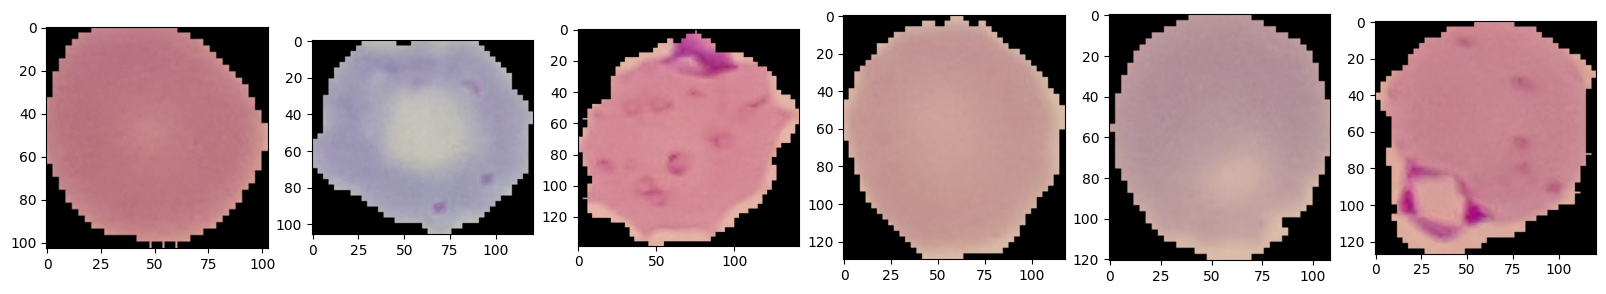

In [ ]:
plt.figure(figsize=[20,5])

# Taking N number of elements (images) from the dataset.
n = 6
for i, data in enumerate(dataset[0].take(n)):
  plt.subplot(100 + n * 10 + (i+1))
  plt.imshow(data[0])

plt.show()

In [ ]:
testset = tf.data.Dataset.range(10)
testset = testset.skip(5)
print(list(testset.as_numpy_iterator()))

[5, 6, 7, 8, 9]


In [ ]:
testset = tf.data.Dataset.range(10)
train, val, test = split_dataset(testset, 0.6, 0.2, 0.2)

print(list(train.as_numpy_iterator()))
print(list(val.as_numpy_iterator()))
print(list(test.as_numpy_iterator()))

print("-"*30)
train, val, test = split_dataset(testset, 0.6, 0, 0.2)

print(list(train.as_numpy_iterator()))
print(list(val.as_numpy_iterator()))
print(list(test.as_numpy_iterator()))

[0, 1, 2, 3, 4, 5]
[6, 7]
[8, 9]
------------------------------
[0, 1, 2, 3, 4, 5]
[]
[6, 7, 8, 9]


# Malaria Prediction

In [4]:
def split_dataset(dataset: tf.data.Dataset, train_ratio: float, val_ratio: float, test_ratio: float) -> tuple[tf.data.Dataset, tf.data.Dataset, tf.data.Dataset]:
  size = len(dataset)
  train_dataset = dataset.take(int(size * train_ratio))
  val_dataset = dataset.skip(int(size * train_ratio)).take(int(size * val_ratio))
  test_dataset = dataset.skip(int(size * (train_ratio + val_ratio)))

  return train_dataset, val_dataset, test_dataset


def plot_img(dataset: tf.data.Dataset):
  rows = 4
  cols = 4
  plt.figure(figsize=[5,6])
  for i, (image, label) in enumerate(dataset):
    # print(image[112,112])
    if len(image.shape) <= 3:
      plt.subplot(rows, cols, i+1)
      plt.imshow(image)
      plt.axis("off")
      plt.title(dataset_info.features["label"].int2str(label))
    else:
      for j in range(image.shape[0]):
        if j > rows * cols - 1: break
        plt.subplot(rows, cols, j + 1)
        plt.imshow(image[j])
        plt.axis("off")
        plt.title(dataset_info.features["label"].int2str(label[j].numpy()))
  plt.show()


IMG_SIZE = 224
# passing the label because tf.data.Dataset.map() passes it as well.
def resize_and_normalize(image, label):
  # divinding by 255.0 element wise.
  new_img = tf.image.resize(image, (IMG_SIZE, IMG_SIZE)) / 255.0
  return new_img, label

In [5]:
train_dataset, val_dataset, test_dataset = split_dataset(dataset[0], 0.8, 0.1, 0.1)

train_dataset = train_dataset.map(resize_and_normalize).shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

val_dataset = val_dataset.map(resize_and_normalize).shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

# It's useless to shuffle and prefetch the test_dataset because it's not used for training.
# It's still necessary to batch it since the model expects the inputs to be in batches though.
test_dataset = test_dataset.map(resize_and_normalize).batch(1)

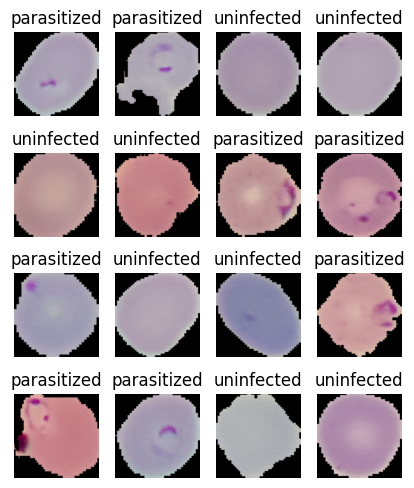

In [6]:
# the output changes based on if you passed through resize_and_normalize or not.
# WARNING: the dataset must NOT be inside batches.
# NOTE: it actually may be inside batches now
plot_img(train_dataset.take(1))

# Sequential API

In [ ]:
# Conv2D -> Extracts features.
# MaxPool2D -> Extracts the most important features using max() in the elements of a cell of size pool_size * pool_size.
# Using relu as activation instead of sigmoid may increase the performance (computational cost) while training.
# BatchNormalization -> When inputs to a layer are normalized, it becomes easier for the model to learn the important features in a more stable manner.

model = tf.keras.Sequential([
    Input(shape=(IMG_SIZE, IMG_SIZE, 3)),

    Conv2D(filters=6, kernel_size=5, strides=1, padding="valid", activation="relu"),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    # In this model, the number of filters (6 and then 16) represents the number of feature maps the convolutional
    # layers will learn. By starting with fewer filters (6) in the first layer, we're keeping the initial computation
    # lower and focusing on learning simpler, broad features from the input image, such as edges and basic shapes.
    # As we go deeper in the network, increasing the filters to 16 allows the model to learn more complex features
    # since the image resolution has been reduced by the pooling layers, and there’s less spatial information to process.
    Conv2D(filters=16, kernel_size=5, strides=1, padding="valid", activation="relu"),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
    Flatten(),

    Dense(100, activation="relu"),
    BatchNormalization(),
    Dense(10, activation="relu"),
    BatchNormalization(),
    # 1 because even if it's 'uninfected' or 'parasitized', we just want 0 OR 1 as output.
    Dense(1, activation="sigmoid")
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 220, 220, 6)         │             456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 220, 220, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 110, 110, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 106, 106, 16)        │           2,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 106, 106, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 53, 53, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 44944)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 100)                 │       4,494,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 10)                  │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 10)                  │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,498,921 (17.16 MB)

 Trainable params: 4,498,657 (17.16 MB)

 Non-trainable params: 264 (1.03 KB)

In [ ]:
model.compile(
    optimizer = Adam(learning_rate=0.1),
    loss = BinaryCrossentropy(),
    metrics = ["accuracy"]
)

In [ ]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=5, verbose=1)

Epoch 1/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 52s 69ms/step - accuracy: 0.6517 - loss: 0.6368 - val_accuracy: 0.5053 - val_loss: 1.9063
Epoch 2/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 77s 64ms/step - accuracy: 0.8344 - loss: 0.3799 - val_accuracy: 0.5292 - val_loss: 0.5863
Epoch 3/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 81s 64ms/step - accuracy: 0.9269 - loss: 0.2301 - val_accuracy: 0.9372 - val_loss: 0.2228
Epoch 4/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 53s 77ms/step - accuracy: 0.9429 - loss: 0.1911 - val_accuracy: 0.9448 - val_loss: 0.1795
Epoch 5/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 72s 63ms/step - accuracy: 0.9487 - loss: 0.1685 - val_accuracy: 0.9256 - val_loss: 0.3235
Epoch 6/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 83s 65ms/step - accuracy: 0.9483 - loss: 0.1644 - val_accuracy: 0.9470 - val_loss: 0.1760
Epoch 7/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 90s 76ms/step - accuracy: 0.9504 - loss: 0.1559 - val_accuracy: 0.9140 - val_loss: 0.8905
Epoch 8/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 74s 64ms/step - accuracy: 0.9525 - loss: 0.1477 - 

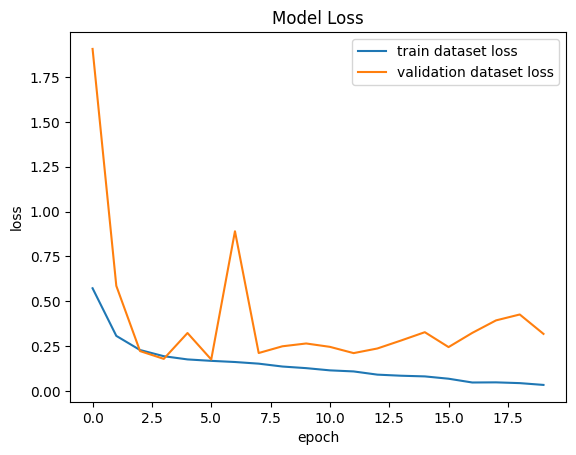

In [ ]:
plt.figure()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train dataset loss", "validation dataset loss"])
plt.title("Model Loss")
plt.show()

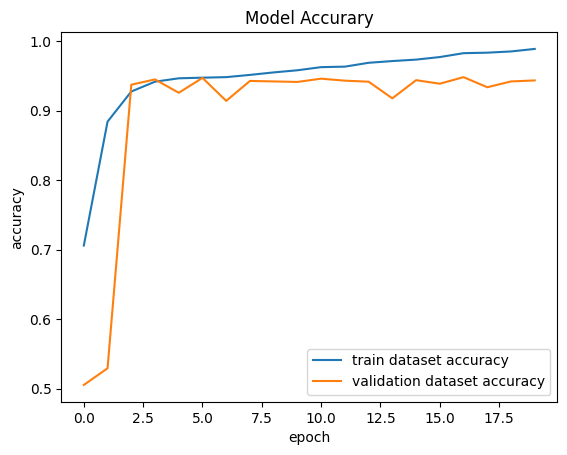

In [ ]:
plt.figure()
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model Accurary")
plt.legend(["train dataset accuracy", "validation dataset accuracy"])
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

In [ ]:
model.evaluate(test_dataset.take(1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - accuracy: 1.0000 - loss: 1.7809e-09


[1.7808595709212227e-09, 1.0]

In [ ]:
model.predict(test_dataset.take(1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step


array([[0.9998766]], dtype=float32)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


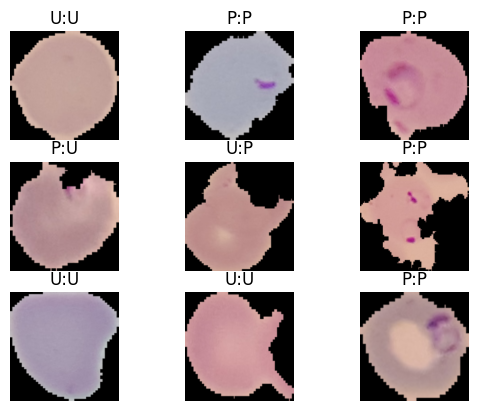

In [ ]:
def parasited_or_not(x):
  if x < 0.5:
    return "P"
  else:
    return "U"

width = 3
height = 3

plt.figure()
for i, (image, label) in enumerate(test_dataset.take(width*height)):
  plt.subplot(width, height, i+1)
  plt.imshow(image[0])
  plt.axis("off")
  pred = model.predict(image)[0][0]
  plt.title(str(parasited_or_not(label.numpy()[0])) + ":" + str(parasited_or_not(pred)))

plt.show()

In [ ]:
model.save("mymodel.keras")
model.save("mymodel.h5")

# Functional API

In [10]:
input = Input(shape=(IMG_SIZE, IMG_SIZE, 3), name = "Input_Image")

# You could put all these togheter inside tf.keras.Sequential and feed it to Flatten()(sequential)
x = Conv2D(filters=6, kernel_size=5, strides=1, padding="valid", activation="relu")(input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=2, strides=2)(x)
x = Conv2D(filters=16, kernel_size=5, strides=1, padding="valid", activation="relu")(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=2, strides=2)(x)

x = Flatten()(x)

x = Dense(100, activation="relu")(x)
x = BatchNormalization()(x)
x = Dense(10, activation="relu")(x)
x = BatchNormalization()(x)
output = Dense(1, activation="sigmoid")(x)

fun_model = Model(input, output, name="Linet_Model")
fun_model.summary()

Model: "Linet_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_Image (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 220, 220, 6)    │           456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 220, 220, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 110, 110, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 106, 106, 16)   │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 106, 106, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 53, 53, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 44944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │     4,494,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,498,921 (17.16 MB)

 Trainable params: 4,498,657 (17.16 MB)

 Non-trainable params: 264 (1.03 KB)

In [11]:
fun_model.compile(
    optimizer = Adam(learning_rate=0.1),
    loss = BinaryCrossentropy(),
    metrics = ["accuracy"]
)

In [13]:
# with tf.device("GPU:0"):
history = fun_model.fit(train_dataset, validation_data=val_dataset, epochs=5, verbose=1)

Epoch 1/5


2024-10-26 01:29:26.751168: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 17977600 exceeds 10% of free system memory.
2024-10-26 01:29:28.298618: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2024-10-26 01:29:28.355098: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 19267584 exceeds 10% of free system memory.
2024-10-26 01:29:28.374174: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 19267584 exceeds 10% of free system memory.
I0000 00:00:1729916968.387851    5977 service.cc:148] XLA service 0x7f2a10015e70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729916968.390149    5977 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1050, Compute Capability 6.1
2024-10-26 01:29:28.587789: I tensorflow/compiler/mlir/te

  1/689 ━━━━━━━━━━━━━━━━━━━━ 2:24:06 13s/step - accuracy: 0.5625 - loss: 0.7882

I0000 00:00:1729916977.119782    5977 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-10-26 01:29:37.159280: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 19267584 exceeds 10% of free system memory.
2024-10-26 01:29:37.206113: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 19267584 exceeds 10% of free system memory.


688/689 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8102 - loss: 0.4353

2024-10-26 01:30:09.241682: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[30,6,220,220]{3,2,1,0}, u8[0]{0}) custom-call(f32[30,3,224,224]{3,2,1,0}, f32[6,3,5,5]{3,2,1,0}, f32[6]{0}), window={size=5x5}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-10-26 01:30:09.473434: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[30,16,106,106]{3,2,1,0}, u8[0]{0}) custom-call(f32[30,6,110,110]{3,2,1,0}, f32[16,6,5,5]{3,2,1,0}, f32[16]{0}), window={size=5x5}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn

689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.8103 - loss: 0.4352

2024-10-26 01:30:19.217494: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[32,6,220,220]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,224,224]{3,2,1,0}, f32[6,3,5,5]{3,2,1,0}, f32[6]{0}), window={size=5x5}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-10-26 01:30:19.457409: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[32,16,106,106]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,6,110,110]{3,2,1,0}, f32[16,6,5,5]{3,2,1,0}, f32[16]{0}), window={size=5x5}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn

689/689 ━━━━━━━━━━━━━━━━━━━━ 59s 67ms/step - accuracy: 0.8103 - loss: 0.4350 - val_accuracy: 0.6726 - val_loss: 5.1217
Epoch 2/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 45s 65ms/step - accuracy: 0.9103 - loss: 0.2725 - val_accuracy: 0.5122 - val_loss: 32.2596
Epoch 3/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 44s 63ms/step - accuracy: 0.8983 - loss: 0.2982 - val_accuracy: 0.4955 - val_loss: 1.4569
Epoch 4/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 37s 53ms/step - accuracy: 0.9380 - loss: 0.2027 - val_accuracy: 0.9318 - val_loss: 0.3734
Epoch 5/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 40s 58ms/step - accuracy: 0.8930 - loss: 0.2638 - val_accuracy: 0.8617 - val_loss: 0.6160


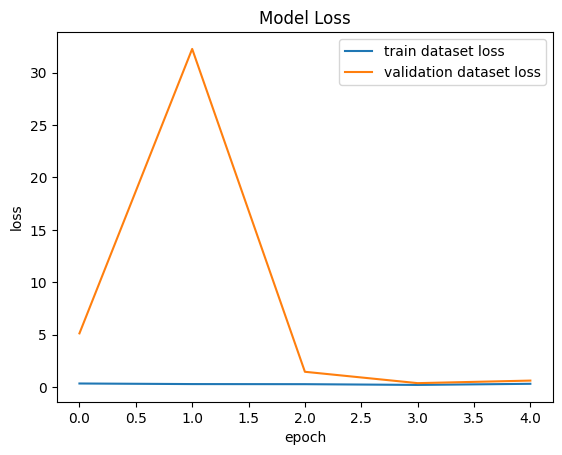

In [14]:
plt.figure()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train dataset loss", "validation dataset loss"])
plt.title("Model Loss")
plt.show()

# Subclassing

In [6]:
class FeatureExtractor(Layer):
  def __init__(self, filters=8, kernel_size=3, k_strides=1, padding="valid", activation="relu", pool_size=2, pool_strides=2):
    super(FeatureExtractor, self).__init__()

    self.conv_1 = Conv2D(filters = filters, kernel_size=kernel_size, strides=k_strides, padding=padding, activation=activation)
    self.batchn_1 = BatchNormalization()
    self.pool_1 = MaxPool2D(pool_size=pool_size, strides=2*pool_strides)
    
    # self.conv_2 = Conv2D(filters = math.ceil(filters*2.5), kernel_size=kernel_size, strides=k_strides, padding=padding, activation=activation)
    self.conv_2 = Conv2D(filters = filters*2, kernel_size=kernel_size, strides=k_strides, padding=padding, activation=activation)
    self.batchn_2 = BatchNormalization()
    self.pool_2 = MaxPool2D(pool_size=pool_size, strides=2*pool_strides)

  # No, it's NOT the dunder call (__call__).
  def call(self, x_in, training = None):
    x = self.conv_1(x_in)
    x = self.batchn_1(x)
    x = self.pool_1(x)
    
    x = self.conv_2(x)
    x = self.batchn_2(x)
    x_out = self.pool_2(x)
    
    return x_out

class FeatureClassification(Layer):
  def __init__(self, units = 100, activation = "relu"):
    super(FeatureClassification, self).__init__()
    self.dense_1 = Dense(units = units, activation = activation)
    self.batchn_1 = BatchNormalization()
    # self.dense_2 = Dense(units = math.ceil(units / 10), activation = activation)
    self.dense_2 = Dense(units = 10, activation = activation)
    self.batchn_2 = BatchNormalization()
    self.dense_out = Dense(units = 1, activation = "sigmoid")

  def call(self, x_in, training = None):
    x = self.dense_1(x_in)
    x = self.batchn_1(x)
    x = self.dense_2(x)
    x = self.batchn_2(x)
    x_out = self.dense_out(x)
    return x_out

class LenetModel(Model):
  def __init__(self):
    super(LenetModel, self).__init__()
    # self.feature_extractor = FeatureExtractor(8, 3, 1, "valid", "relu", 2)
    self.feat_ext = FeatureExtractor()
    self.flatten = Flatten()
    self.feat_classf = FeatureClassification()
    
  # WARNING: apparently, if you miss this 'training' parameter here,
  # your model doesnt perform as it should.
  def call(self, x, training = None):
    x = self.feat_ext(x)
    x = self.flatten(x)
    x = self.feat_classf(x)
    return x

subc_model = LenetModel()
subc_model(tf.zeros([1,224,224,3]))
subc_model.summary()

subc_model.compile(
    optimizer = Adam(learning_rate=0.1),
    loss = BinaryCrossentropy(),
    metrics = ["accuracy"]
)

I0000 00:00:1729962895.005002   55550 cuda_dnn.cc:529] Loaded cuDNN version 90300


Model: "lenet_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ feature_extractor               │ ?                      │         1,488 │
│ (FeatureExtractor)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (1, 3136)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ feature_classification          │ ?                      │       315,161 │
│ (FeatureClassification)         │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 316,649 (1.21 MB)

 Trainable params: 316,381 (1.21 MB)

 Non-trainable params: 268 (1.05 KB)

In [7]:
history = subc_model.fit(train_dataset, validation_data=val_dataset, epochs=5, verbose=1)

Epoch 1/5


2024-10-26 14:15:03.568443: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
I0000 00:00:1729962903.868794   56430 service.cc:148] XLA service 0x7fe3b4114740 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729962903.869427   56430 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1050, Compute Capability 6.1
2024-10-26 14:15:03.977674: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-26 14:15:07.048956: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[32,8,222,222]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,224,224]{3,2,1,0}, f32[8,3,3,3]{3,2,1,0}, f32[8]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custo

688/689 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.7180 - loss: 0.5485

2024-10-26 14:16:10.531577: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[30,8,222,222]{3,2,1,0}, u8[0]{0}) custom-call(f32[30,3,224,224]{3,2,1,0}, f32[8,3,3,3]{3,2,1,0}, f32[8]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-10-26 14:16:10.969396: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[30,16,54,54]{3,2,1,0}, u8[0]{0}) custom-call(f32[30,8,56,56]{3,2,1,0}, f32[16,8,3,3]{3,2,1,0}, f32[16]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_con

689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.7181 - loss: 0.5484

2024-10-26 14:16:24.567029: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[32,8,222,222]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,224,224]{3,2,1,0}, f32[8,3,3,3]{3,2,1,0}, f32[8]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-10-26 14:16:24.953213: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[32,16,54,54]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,8,56,56]{3,2,1,0}, f32[16,8,3,3]{3,2,1,0}, f32[16]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_con

689/689 ━━━━━━━━━━━━━━━━━━━━ 90s 105ms/step - accuracy: 0.7182 - loss: 0.5482 - val_accuracy: 0.3833 - val_loss: 1.2278
Epoch 2/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 57s 82ms/step - accuracy: 0.9145 - loss: 0.2654 - val_accuracy: 0.8893 - val_loss: 0.5321
Epoch 3/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 56s 81ms/step - accuracy: 0.9352 - loss: 0.2044 - val_accuracy: 0.9045 - val_loss: 0.2987
Epoch 4/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 59s 85ms/step - accuracy: 0.9368 - loss: 0.1990 - val_accuracy: 0.9339 - val_loss: 0.2183
Epoch 5/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 58s 85ms/step - accuracy: 0.9362 - loss: 0.2028 - val_accuracy: 0.8309 - val_loss: 0.4926


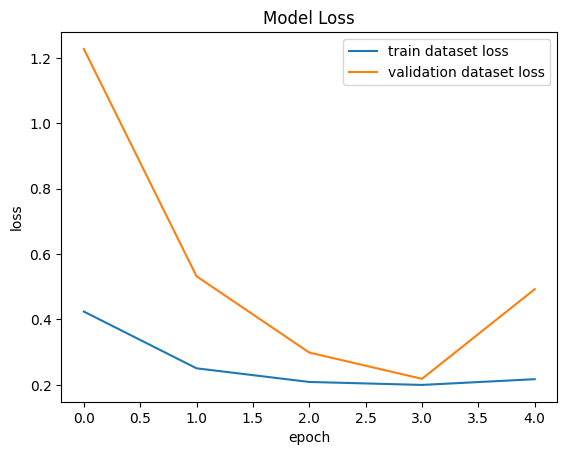

In [11]:
plt.figure()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train dataset loss", "validation dataset loss"])
plt.title("Model Loss")
plt.show()

# Custom Layers

In [15]:
class CustomDenseLayer(Layer):
    def __init__(self, units, activation):
        super(CustomDenseLayer, self).__init__()
        """
        units => specifies the number of neurons (or output units) in the layer. 
        It defines the size of the output vector produced by the layer when it 
        processes the input features.
        """
        self.c_units = units
        self.c_activation = activation

    def build(self, input_features_shape):
        # self.add_weight(...) comes from the superclass.
        
        # input_features (passed to call()) will have a shape of:
        # - (batch, cols)
        # so we need this c_weights to have shape of: 
        # - (cols, c_units)
        self.c_weight = self.add_weight(shape = (input_features_shape[-1], self.c_units), initializer = "random_normal", trainable = True)
        self.c_bias  = self.add_weight(shape = (self.c_units,), initializer = "zeros", trainable = True)
    
    def call(self, input_features):
        pre_output = tf.matmul(input_features, self.c_weight) + self.c_bias

        if self.c_activation == "relu":
            return tf.nn.relu(pre_output)
        
        if self.c_activation == "sigmoid":
            return tf.math.sigmoid(pre_output)
        
        return pre_output

In [19]:
custom_layer_model = tf.keras.Sequential([
    Input(shape = (IMG_SIZE, IMG_SIZE, 3)),
    
    Conv2D(filters=6, kernel_size=5, strides=1, padding="valid", activation="relu"),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Conv2D(filters=16, kernel_size=5, strides=1, padding="valid", activation="relu"),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
    
    Flatten(),

    CustomDenseLayer(100, activation="relu"),
    BatchNormalization(),
    CustomDenseLayer(10, activation="relu"),
    BatchNormalization(),
    CustomDenseLayer(1, activation="sigmoid")
])

custom_layer_model.summary()
custom_layer_model.compile(
    optimizer=Adam(learning_rate=0.1),
    loss = BinaryCrossentropy(from_logits=False),
    metrics = [BinaryAccuracy()]
)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 220, 220, 6)    │           456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 220, 220, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 110, 110, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 106, 106, 16)   │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 106, 106, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 53, 53, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 44944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_dense_layer_12           │ (None, 100)            │     4,494,500 │
│ (CustomDenseLayer)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_dense_layer_13           │ (None, 10)             │         1,010 │
│ (CustomDenseLayer)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_dense_layer_14           │ (None, 1)              │            11 │
│ (CustomDenseLayer)              │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,498,921 (17.16 MB)

 Trainable params: 4,498,657 (17.16 MB)

 Non-trainable params: 264 (1.03 KB)

In [20]:
history = custom_layer_model.fit(train_dataset, validation_data=val_dataset, epochs=5, verbose=1)

Epoch 1/5


2024-10-26 14:24:23.706272: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[32,6,220,220]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,224,224]{3,2,1,0}, f32[6,3,5,5]{3,2,1,0}, f32[6]{0}), window={size=5x5}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-10-26 14:24:24.632321: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[32,16,106,106]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,6,110,110]{3,2,1,0}, f32[16,6,5,5]{3,2,1,0}, f32[16]{0}), window={size=5x5}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn

688/689 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - binary_accuracy: 0.6871 - loss: 0.5878

2024-10-26 14:26:13.048493: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[30,6,220,220]{3,2,1,0}, u8[0]{0}) custom-call(f32[30,3,224,224]{3,2,1,0}, f32[6,3,5,5]{3,2,1,0}, f32[6]{0}), window={size=5x5}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-10-26 14:26:13.876277: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[30,16,106,106]{3,2,1,0}, u8[0]{0}) custom-call(f32[30,6,110,110]{3,2,1,0}, f32[16,6,5,5]{3,2,1,0}, f32[16]{0}), window={size=5x5}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn

689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - binary_accuracy: 0.6872 - loss: 0.5876

2024-10-26 14:26:29.389550: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[32,6,220,220]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,224,224]{3,2,1,0}, f32[6,3,5,5]{3,2,1,0}, f32[6]{0}), window={size=5x5}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-10-26 14:26:30.187183: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[32,16,106,106]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,6,110,110]{3,2,1,0}, f32[16,6,5,5]{3,2,1,0}, f32[16]{0}), window={size=5x5}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn

689/689 ━━━━━━━━━━━━━━━━━━━━ 150s 174ms/step - binary_accuracy: 0.6874 - loss: 0.5875 - val_binary_accuracy: 0.8258 - val_loss: 0.8841
Epoch 2/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 102s 147ms/step - binary_accuracy: 0.9007 - loss: 0.2844 - val_binary_accuracy: 0.9245 - val_loss: 0.2261
Epoch 3/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 102s 148ms/step - binary_accuracy: 0.9237 - loss: 0.2351 - val_binary_accuracy: 0.5038 - val_loss: 0.9006
Epoch 4/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 102s 148ms/step - binary_accuracy: 0.9295 - loss: 0.2084 - val_binary_accuracy: 0.9260 - val_loss: 0.3234
Epoch 5/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 102s 148ms/step - binary_accuracy: 0.9372 - loss: 0.1963 - val_binary_accuracy: 0.9162 - val_loss: 0.2616


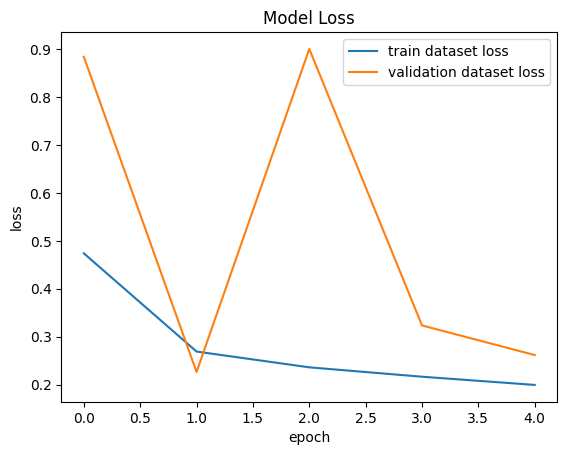

In [21]:
plt.figure()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train dataset loss", "validation dataset loss"])
plt.title("Model Loss")
plt.show()